<a href="https://colab.research.google.com/github/lupis30puc/BERT_interpretation_with_RF/blob/main/BERT_features_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
import math
import random

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

import time
import pickle
#from treeinterpreter import treeinterpreter as ti
import joblib
#from transformers import BertTokenizer
import torch

In [ ]:
# function so that the graphs look good 
def set_plotting_style():
  tw = 1.5
  rc = {'lines.linewidth': 2,
              'axes.labelsize': 18,
              'axes.titlesize': 21,
              'xtick.major' : 16,
              'ytick.major' : 16,
              'xtick.major.width': tw,
              'xtick.minor.width': tw,
              'ytick.major.width': tw,
              'ytick.minor.width': tw,
              'xtick.labelsize': 'large',
              'ytick.labelsize': 'large',
              'font.family': 'sans',
              'weight':'bold',
              'grid.linestyle': ':',
              'grid.linewidth': 1.5,
              'grid.color': '#ffffff',
              'mathtext.fontset': 'stixsans',
              'mathtext.sf': 'fantasy',
              'legend.frameon': True,
              'legend.fontsize': 12, 
            "xtick.direction": "in","ytick.direction": "in"}

  plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
  plt.rc('mathtext', fontset='stixsans', sf='sans')
  sns.set_style('ticks', rc=rc)
  sns.set_context('notebook', rc=rc)


## Loading feature importances and analyzing them 

In [ ]:
ft_imp = pd.read_pickle('/content/drive/MyDrive/Yelp/random_forest/importance_df.pkl')
ft_imp.sort_values(by=['imp'], ascending=False)[:10] #words with important role 

,ids,words,imp
288,2307,great,0.042505
8020,12090,delicious,0.020511
3802,6429,amazing,0.018595
2978,5409,worst,0.016944
279,2293,love,0.015892
2954,5379,friendly,0.015123
373,2409,told,0.014258
5957,9202,horrible,0.014049
327,2356,asked,0.013634
3991,6659,terrible,0.013311


In [ ]:
ft_imp[['words', 'imp']][ft_imp['imp'] > 0.01].sort_values(by=['imp'], ascending=False)

,words,imp
288,great,0.042505
8020,delicious,0.020511
3802,amazing,0.018595
2978,worst,0.016944
279,love,0.015892
2954,friendly,0.015123
373,told,0.014258
5957,horrible,0.014049
327,asked,0.013634
3991,terrible,0.013311


In [ ]:
# checking the least important features
ft_imp.sort_values(by=['imp'], ascending=True)[:10]

,ids,words,imp
8281,12479,ambitious,0.0
10663,16396,offset,0.0
10664,16401,converting,0.0
10665,16402,##iver,0.0
10667,16408,supportive,0.0
10668,16409,##dc,0.0
10669,16412,responds,0.0
10670,16416,##rea,0.0
10671,16417,ein,0.0
10672,16420,sf,0.0


In [ ]:
# checking how many features have 0 importance
ft_imp[['words', 'imp']][ft_imp['imp'] == 0].sort_values(by=['imp'])

,words,imp
1,[CLS],0.0
12082,litter,0.0
12083,hiss,0.0
12084,rumor,0.0
12085,vow,0.0
...,...,...
7274,shy,0.0
7276,greene,0.0
7279,sherman,0.0
7281,reinforced,0.0


In [ ]:
# around 70% of the reviews have no importance according to RF
ft_imp.shape

(16563, 3)

In [ ]:
# saving the part of the importances with actual values on it
ft_importance = ft_imp[['words', 'imp']][ft_imp['imp'] != 0]
ft_importance.shape

(5033, 2)

In [ ]:
# the least important words for the model are these
ft_importance.sort_values(by=['imp'], ascending=True)[:10]

,words,imp
6758,rows,4.274550e-10
1284,guard,9.576851e-10
12470,slots,1.801621e-09
4856,mars,2.153322e-09
15154,##fect,4.475208e-09
3044,runner,5.336877e-09
16464,amazingly,6.469169e-09
480,royal,7.526595e-09
11884,absurd,8.228422e-09
7003,damp,8.954376e-09


In [ ]:
ft_importance.imp.describe()

count    5.033000e+03
mean     1.986887e-04
std      1.132216e-03
min      4.274550e-10
25%      2.543224e-06
50%      1.192466e-05
75%      7.122496e-05
max      4.250529e-02
Name: imp, dtype: float64

In [ ]:
ft_importance['imp_perc'] = ft_importance.imp.apply(lambda x : x*100)
ft_importance['imp_perc'][288]

4.250529437111594

In [ ]:
ft_importance[['words', 'imp_perc']].sort_values(by=['imp_perc'], ascending=False)[:10]

,words,imp_perc
288,great,4.250529
8020,delicious,2.051149
3802,amazing,1.859461
2978,worst,1.694412
279,love,1.589207
2954,friendly,1.512306
373,told,1.425828
5957,horrible,1.404927
327,asked,1.363382
3991,terrible,1.331133


In [ ]:
ft_importance['imp_perc'].sum()

100.0

In [ ]:
# the top 10 most important words make up 18% of the importance
ft_importance['imp_perc'].sort_values(ascending=False)[:10].sum()

18.482334290740276

In [ ]:
ft_importance['imp_perc'][ft_importance['imp_perc'] >= 1].sum()

25.547103513793875

In [ ]:
# 16 words alone out of the 5033 words in total make up 25% of importance
len(ft_importance['imp_perc'][ft_importance['imp_perc'] >= 1])

16

In [ ]:
ft_importance['imp_perc'][ft_importance['imp_perc'] >= 0.28].sum()

50.24830419644204

In [ ]:
# 74 words alone out of the 5033 words in total make up more than 50% of importance
len(ft_importance['imp_perc'][ft_importance['imp_perc'] >= 0.28])

69

In [ ]:
len(ft_importance[ft_importance['imp_perc'] < 0.5][ft_importance['imp_perc'] >= 0.25])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


40

In [ ]:
ft_importance[ft_importance['imp_perc'] < 0.5][ft_importance['imp_perc'] >= 0.25].sort_values(by=['imp'], ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,words,imp,imp_perc
276,got,0.004927,0.492729
172,took,0.004865,0.486467
1775,slow,0.004695,0.469495
6304,awful,0.004672,0.467163
1608,paid,0.004658,0.465850
1596,highly,0.004551,0.455094
433,better,0.004522,0.452165
177,called,0.004309,0.430880
6089,disappointed,0.004157,0.415713
1299,pay,0.004118,0.411755


## Opening the ids appearance data frame

In [ ]:
# opening the x values binary dataframes 
ids_count =pd.read_pickle('/content/drive/MyDrive/Yelp/model_128_/binary_all')
ids_count.shape

(12993, 16563)

In [ ]:
ids_count.head(2)

,[PAD],[CLS],[SEP],a,b,c,d,e,f,g,h,i,j,k,l,n,o,p,q,r,s,t,u,v,w,x,y,z,the,of,and,in,to,was,he,is,as,for,on,with,...,polka,starbucks,adamant,inspecting,##ducted,##pone,##roids,##ppet,##lib,colossal,foreigner,vet,freaks,rosewood,upstate,ks,vo,##tzer,##werk,binoculars,enthusiast,squeak,inflated,bonuses,##rco,penitentiary,##etched,##lster,##nsor,##toy,inhuman,tbs,inspections,disgrace,infused,pudding,stalks,leases,##wil,thyroid
0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
ft_importance.sort_values(by=['imp'], ascending=False)['imp_perc'][:10].sum()

18.482334290740276

In [ ]:
top10 = list(ft_importance.sort_values(by=['imp'], ascending=False)['words'][:10])
top10[0]

'great'

In [ ]:
# the 18 % of importance
for w in top10:  
  print(w + ' appears in ' + str(ids_count[w].sum()) + ' reviews')

great appears in 3368 reviews
delicious appears in 1085 reviews
amazing appears in 1003 reviews
worst appears in 526 reviews
love appears in 1308 reviews
friendly appears in 1511 reviews
told appears in 1077 reviews
horrible appears in 446 reviews
asked appears in 1143 reviews
terrible appears in 440 reviews


In [ ]:
# the 25% of importance
top16 = ft_importance[ft_importance['imp_perc'] >= 1].sort_values(by=['imp'], ascending=False)['words']
top16_count = []
for w in top16:
  top16_count.append(ids_count[w].sum())
  print(w + ' appears in ' + str(ids_count[w].sum()) + ' reviews')

great appears in 3368 reviews
delicious appears in 1085 reviews
amazing appears in 1003 reviews
worst appears in 526 reviews
love appears in 1308 reviews
friendly appears in 1511 reviews
told appears in 1077 reviews
horrible appears in 446 reviews
asked appears in 1143 reviews
terrible appears in 440 reviews
rude appears in 533 reviews
best appears in 1611 reviews
said appears in 1359 reviews
definitely appears in 1211 reviews
minutes appears in 1099 reviews
excellent appears in 584 reviews


[Source for the plot format](https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9)

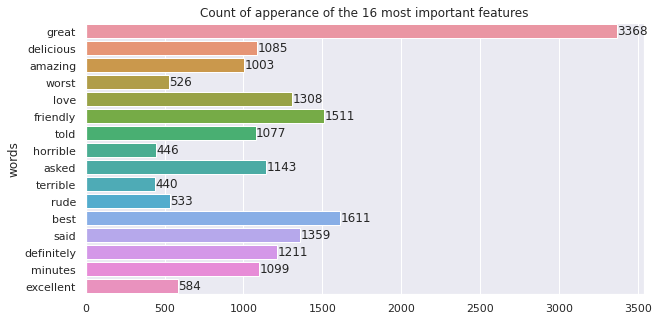

In [ ]:
# plot horizontal barplot
sns.set(rc={'figure.figsize':(10,5)})
ax = sns.barplot(y=top16, x=top16_count)
ax.set(title='Count of apperance of the 16 most important features') # title barplot
# label each bar in barplot
for p in ax.patches:
 height = p.get_height() # height of each horizontal bar is the same
 width = p.get_width() # width (average number of passengers)
 # adding text to each bar
 ax.text(x = width+3, # x-coordinate position of data label, padded 3 to right of bar
 y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
 s = '{:.0f}'.format(width), # data label, formatted to ignore decimals
 va = 'center') # sets vertical alignment (va) to center

In [ ]:
perc_50 = list(ft_importance.sort_values(by=['imp'], ascending=False)['words'][:70])
perc_50[0]

'great'

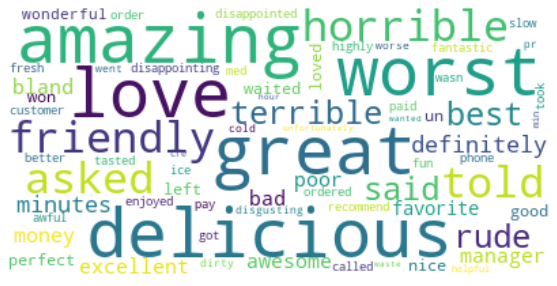

In [ ]:
top70_w = ' '.join([word for word in perc_50])
cloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(top70_w)
plt.figure()
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
top70_ww = dict(zip(perc_50, list(ft_importance.sort_values(by=['imp_perc'], ascending=False)['imp_perc'][:70])))
top70_ww['great']

4.250529437111594

In [ ]:
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")
wc.fit_words(top70_ww)
plt.show()

In [ ]:
wc.to_file('/content/drive/MyDrive/Yelp/top69_most_important.png')

In [ ]:
top69_count = []
for w in perc_50:
  top69_count.append(ids_count[w].sum())
  #print(w + ' appears in ' + str(ids_count[w].sum()) + ' reviews')

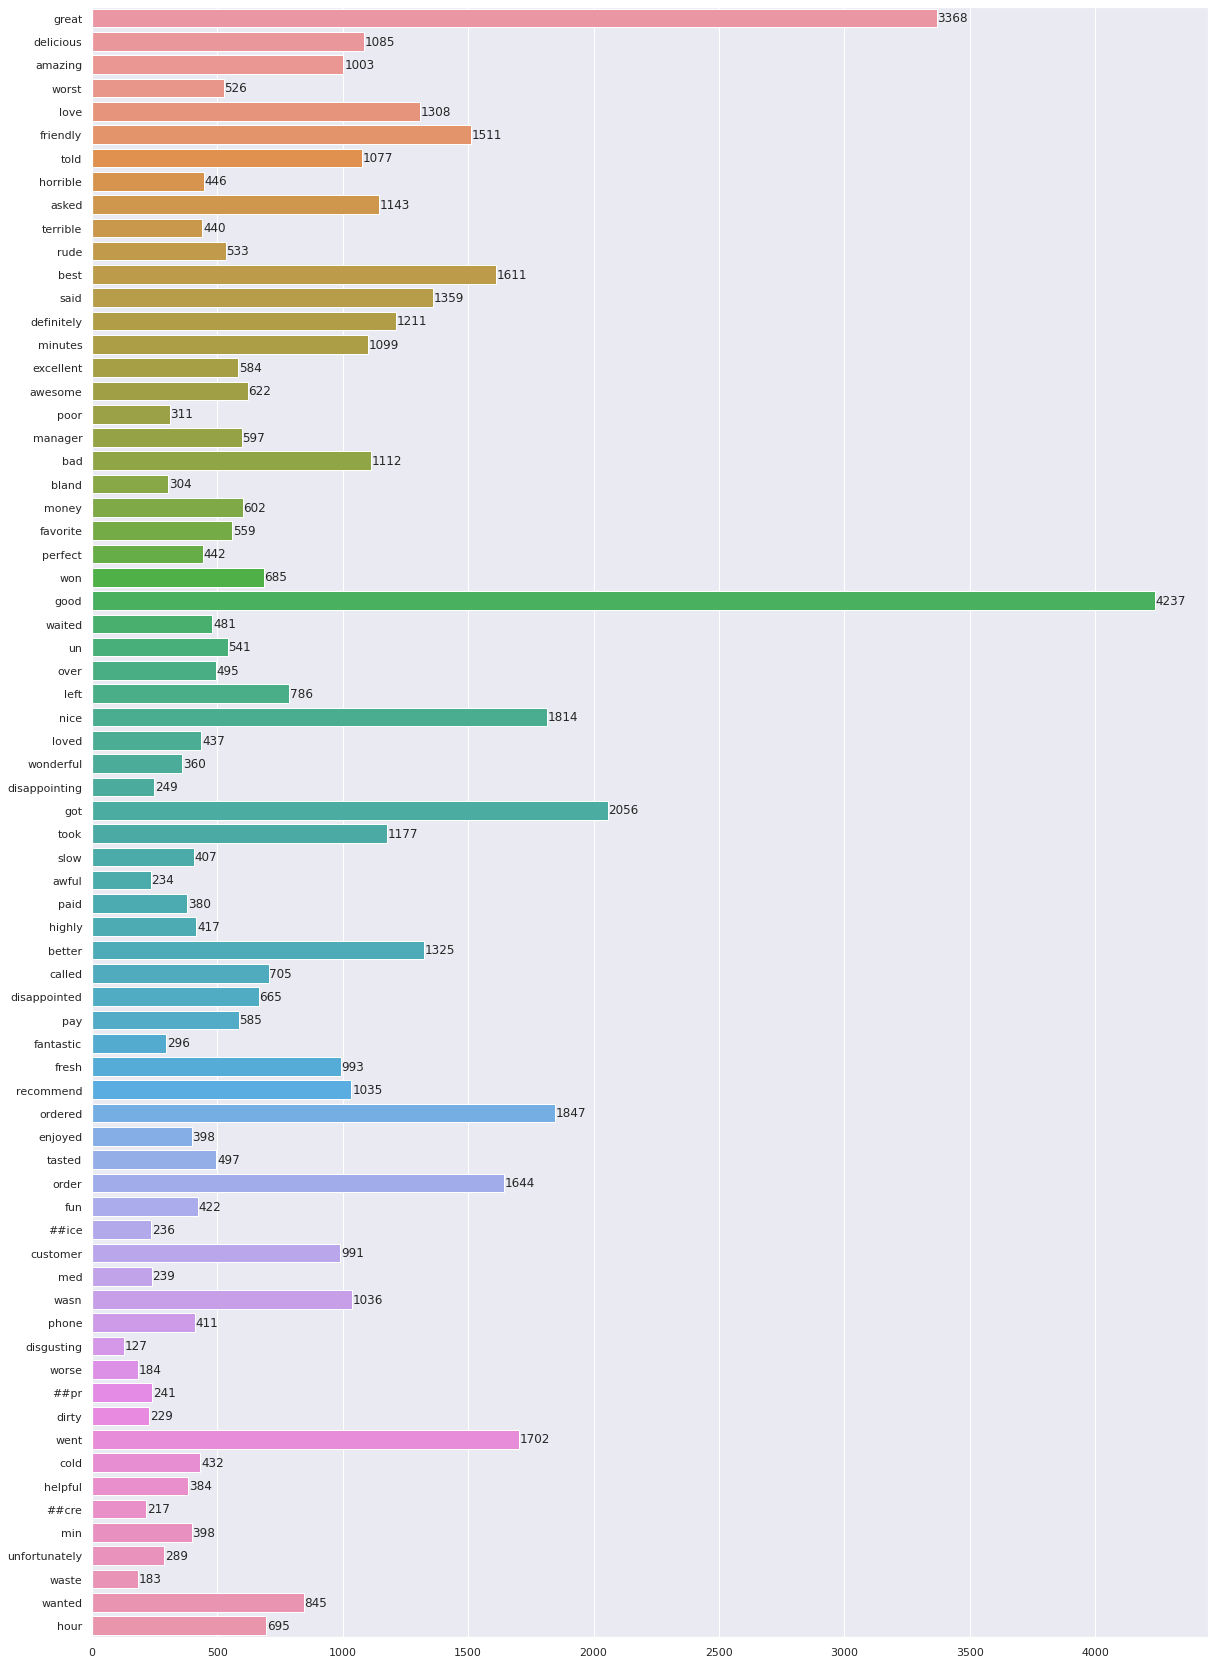

In [ ]:
# plot horizontal barplot
sns.set(rc={'figure.figsize':(20,30)})
ax = sns.barplot(y=perc_50, x=top69_count)
#ax.set(title='Count of apperance of the 16 most important features') # title barplot
# label each bar in barplot
for p in ax.patches:
 height = p.get_height() # height of each horizontal bar is the same
 width = p.get_width() # width (average number of passengers)
 # adding text to each bar
 ax.text(x = width+3, # x-coordinate position of data label, padded 3 to right of bar
 y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
 s = '{:.0f}'.format(width), # data label, formatted to ignore decimals
 va = 'center') # sets vertical alignment (va) to center

## Local contributions 
(also on the features_contributions_analysis notebook)

In [ ]:
all_contribs = pickle.load(open('/content/drive/MyDrive/Yelp/random_forest/all_contribs.pkl', 'rb'))
len(all_contribs)

12993

In [ ]:
all_contribs[0]

array([[ 0.00537429, -0.00537429],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ]])

In [ ]:
all_ids = pickle.load(open('/content/drive/MyDrive/Yelp/random_forest/all_ids.pkl', 'rb'))
len(all_ids)

12993

In [ ]:
#this function is based on the one appearing on https://coderzcolumn.com/tutorials/machine-learning/treeinterpreter-interpreting-tree-based-models-prediction-of-individual-sample
def create_contrbutions_df(contributions, review, features_df, input_ids):
  #extracting only the relevant ids index. the ones that the observed review has
  review_ids = list(features_df[features_df['ids'].isin(input_ids[review])].index) 

  #creating a dictionary of the contributions for the specific id on the observed review
  contribs = {}
  for i in review_ids:
    c = contributions[review][i] 
    feature = features_df['words'][i] 
    contribs[feature] = list(c)
  
  # creating a dataframe out of it 
  contrib_df = pd.DataFrame(data=contribs.values(), index = contribs.keys(), columns=["negative", "positive"])
  # inserting the predicted label at the end
  prediction = contrib_df[["negative", "positive"]].sum()
  contrib_df.loc["PREDICTION"] = np.argmax(prediction)
  return contrib_df

In [ ]:
df = create_contrbutions_df(all_contribs, 5468, ft_imp, all_ids)
df

,negative,positive
[CLS],0.000000,0.000000
[SEP],0.000000,0.000000
##s,-0.000075,0.000075
time,0.001069,-0.001069
said,0.030959,-0.030959
...,...,...
towels,0.002572,-0.002572
overwhelmingly,0.000000,0.000000
bingo,0.000000,0.000000
##nery,0.000000,0.000000


In [ ]:
#relevant-top positive features
df[df['positive'] > 0.01].sort_values(by=['positive'], ascending=False)

,negative,positive
PREDICTION,1.000000,1.000000
awesome,-0.032386,0.032386
loved,-0.030384,0.030384
great,-0.030374,0.030374
friendly,-0.025242,0.025242
favorite,-0.023705,0.023705
fun,-0.018110,0.018110


In [ ]:
#relevant-top positive features
df[df['negative'] > 0.01].sort_values(by=['positive'], ascending=True)

,negative,positive
said,0.030959,-0.030959
minutes,0.027889,-0.027889
called,0.020335,-0.020335
took,0.016903,-0.016903
ask,0.014865,-0.014865
got,0.014740,-0.014740
wasn,0.013094,-0.013094
better,0.011073,-0.011073
PREDICTION,1.000000,1.000000


In [ ]:
#relevant/top negative
df[df['negative'] > 0.01].sort_values(by=['negative'], ascending=True)

,negative,positive
better,0.011073,-0.011073
wasn,0.013094,-0.013094
got,0.014740,-0.014740
ask,0.014865,-0.014865
took,0.016903,-0.016903
called,0.020335,-0.020335
minutes,0.027889,-0.027889
said,0.030959,-0.030959
PREDICTION,1.000000,1.000000


In [ ]:
summary1 = pd.read_pickle('/content/drive/MyDrive/Yelp/results1.pkl')
summary1['index'][5833]

In [ ]:
summary2.clean_text[13]

'fingers hand pretty decent arena way way seats course sucks shoot mid level feel like touch performers leg know breathing air large screens main stage necessarily miss action feel like watching flea circus spaces rows fairly decent petite lil thing space issue violating stairs aren super scary steep gals stilettos afraid plenty bathroom stalls concession stands rent binoculars'

In [ ]:
summary2 = pd.read_pickle('/content/drive/MyDrive/Yelp/results2.pkl')
summary2

,index,text,label,categories,clean_text,category,length,bert_pred,positive_c,negative_c,rf_pred
0,555,I went to the Fragrance department to pick up ...,0,"Department Stores, Fashion, Men's Clothing, Wo...",went fragrance department pick bottle versace ...,Other Industries,54,0,"{'mall': 0.0014292788633557055, 'er': 0.001085...","{'asked': 0.051271851229870706, 'said': 0.0446...",0
1,855,My friend found a hair in his food. Definitely...,0,"Arts & Entertainment, Nightlife, Breakfast & B...",friend hair food definitely lost appetite pull...,Restaurant Industry,19,0,"{'definitely': 0.07466639315626142, 'good': 0....","{'wasn': 0.043493839409041064, 'lost': 0.02648...",0
2,1158,Some selections are pretty good. Unfortunately...,0,"Asian Fusion, Event Planning & Services, Resta...",selections pretty good unfortunately dishes we...,Hotel Industry,21,0,"{'great': 0.06918939498428471, 'good': 0.01815...","{'unfortunately': 0.08739752310228917, 'wasn':...",0
3,1404,WTF!! WTF!! WTF!!\n1st off this place was do...,0,"Laundry Services, Dry Cleaning & Laundry, Loca...",wtf wtf wtf place downright filthy walked righ...,Service Industry,75,0,"{'clean': 0.012399755825582762, 'soft': 0.0095...","{'said': 0.0466807978957219, 'dirty': 0.039079...",0
4,3825,We got very lucky as far as insurance coverage...,0,"Shopping, Health & Medical, Ophthalmologists, ...",got lucky far insurance coverage goes new glas...,Other Industries,33,0,"{'knowledge': 0.0352074956753434, 'professiona...","{'left': 0.04591727101771179, 'took': 0.034729...",0
5,3954,The office manager is not accountable and has ...,0,"Urgent Care, Physical Therapy, Health & Medica...",office manager accountable cost job misplacing...,Other Industries,94,0,"{'great': 0.05475795823907564, 'staff': 0.0069...","{'told': 0.07567785760798497, 'manager': 0.063...",0
6,4210,"They have implemented a $15 MINIMUM fee, regar...",0,"Local Services, Printing Services",implemented minimum fee regardless papers need...,Service Industry,11,0,{'[PAD]': 0.0002893095330370151},"{'need': 0.024926748908336342, 'website': 0.01...",0
7,4281,Worst experience ever. I've They charged me a ...,0,"Hotels & Travel, Car Rental",worst experience charged time booking rental c...,Hotel Industry,53,0,"{'recommend': 0.018213364599606065, 'price': 0...","{'worst': 0.0714872458168004, 'horrible': 0.06...",0
8,5013,No stars should be an option. Shitty connectio...,0,"Internet Service Providers, Home Services, Pro...",stars option shitty connections store turn old...,Service Industry,25,0,"{'best': 0.06604296374981053, '##m': 0.0055044...","{'money': 0.08283710883889309, 'ask': 0.025563...",0
9,5231,Let me start by saying that I absolutely LOVED...,0,"Restaurants, Spanish, Cuban, Caribbean",let start saying absolutely loved food dinner ...,Restaurant Industry,25,0,"{'loved': 0.06388472875707339, 'spot': 0.03130...","{'average': 0.03416436856008317, 'saying': 0.0...",1


In [ ]:
summary3 = pd.read_csv('/content/drive/MyDrive/Yelp/results3.csv')
summary3

,Unnamed: 0,index,label,bert_pred,rf_pred,category,length,r_pos_c,r_neg_c
0,0,5685,1,1,1.0,Restaurant Industry,27,"['helpful: 0.069', 'good: 0.026', 'reasonably:...","['company: 0.017', 'going: 0.016']"
1,1,6654,1,1,1.0,Hotel Industry,27,"['fantastic: 0.106', 'spot: 0.041', 'lovely: 0...",['know: 0.019']
2,2,8455,1,1,1.0,Beauty Industry,28,"['definitely: 0.069', 'best: 0.063', 'perfectl...",['like: 0.012']
3,3,8662,1,1,1.0,Other Industries,32,"['amazing: 0.06', 'awesome: 0.06', 'great: 0.0...",['minutes: 0.068']
4,4,8973,1,1,1.0,Service Industry,26,"['nice: 0.067', 'fresh: 0.059']",[]
